# **Préparation :** Importation des Librairies et des Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration des styles de visualisation et des variables de temps
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
START_YEAR = 1970
END_YEAR = 2023

# --- Importation des datasets ---

# 1. Températures par Pays (Berkeley Earth)
df_temp_country = pd.read_csv("/content/drive/MyDrive/Climat Cameroun/Temperatures_mondiales_BERKELEY EARTH/GlobalLandTemperaturesByCountry.csv")

# 2. Émissions de CO2 par Pays (World Bank) - Ignorer les 4 premières lignes
df_co2 = pd.read_csv("/content/drive/MyDrive/Climat Cameroun/Emission de C02 par pays_WORLD BANK/API_EN.GHG.CO2.PC.CE.AR5_DS2_en_csv_v2_127841.csv", skiprows=4)

# 3. Métadonnées des Pays (World Bank) - Essentiel pour la colonne 'Region' (Continent)
df_metadata_country = pd.read_csv("/content/drive/MyDrive/Climat Cameroun/Emission de C02 par pays_WORLD BANK/Metadata_Country_API_EN.GHG.CO2.PC.CE.AR5_DS2_en_csv_v2_127841.csv")

# 4. Anomalies Climatiques (NOAA - gsoy sample) - Sera utilisé au Jour 2/3
df_anomalies = pd.read_csv("/content/drive/MyDrive/Climat Cameroun/Anomalies_climatiques_NOAA/gsoy_sample_csv.csv")


print("Importation des 4 datasets terminée. Inspection des structures initiales:")
print(f"Température Pays: {df_temp_country.shape} | CO2: {df_co2.shape} | Anomalies: {df_anomalies.shape}")

Importation des 4 datasets terminée. Inspection des structures initiales:
Température Pays: (577462, 4) | CO2: (266, 70) | Anomalies: (2, 78)


#**Nettoyage, Transformation et Fusion des Données**

2.1. Nettoyage et Agrégation des Températures (df_temp_country)

In [2]:
# Conversion des dates et extraction de l'année
df_temp_country['dt'] = pd.to_datetime(df_temp_country['dt'])
df_temp_country['year'] = df_temp_country['dt'].dt.year

# Filtrage pour la période 1970-2023
df_temp_filtered = df_temp_country[
    (df_temp_country['year'] >= START_YEAR) & (df_temp_country['year'] <= END_YEAR)
].copy()

# Suppression des valeurs manquantes dans la colonne de température (mensuelle)
df_temp_filtered.dropna(subset=['AverageTemperature'], inplace=True)

# Calcul de la température moyenne ANNUELLE par pays
df_temp_agg = df_temp_filtered.groupby(['year', 'Country'])['AverageTemperature'].mean().reset_index()
df_temp_agg.rename(columns={'AverageTemperature': 'Avg_Temp_C'}, inplace=True)

print("Agrégation des températures terminée. Dimensions:", df_temp_agg.shape)

Agrégation des températures terminée. Dimensions: (10648, 3)


2.2. Nettoyage et Transformation du $CO_{2}$ (df_co2)

In [3]:
# Définir la plage d'années (colonnes) à conserver
years_to_keep = [str(y) for y in range(START_YEAR, END_YEAR + 1)]
id_vars_co2 = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']

# Transformation du format large (années en colonnes) en format long (melt/unpivot)
df_co2_melt = df_co2.melt(
    id_vars=id_vars_co2,
    value_vars=years_to_keep,
    var_name='year',
    value_name='CO2_Per_Capita'
)

# Conversion de l'année en entier et suppression des NaN dans les données CO2
df_co2_melt['year'] = pd.to_numeric(df_co2_melt['year'], errors='coerce')
df_co2_melt.dropna(subset=['CO2_Per_Capita'], inplace=True)

print("\nTransformation du CO2 terminée. Dimensions:", df_co2_melt.shape)


Transformation du CO2 terminée. Dimensions: (13554, 6)


2.3. Fusion des Données et Ajout de la Région/Continent

In [4]:
# 1. Fusion de la Température et du CO2
df_merged = pd.merge(
    df_temp_agg,
    df_co2_melt,
    left_on=['year', 'Country'],
    right_on=['year', 'Country Name'],
    how='inner'
)

# 2. Fusion avec les Métadonnées pour obtenir la Région (Continent)
df_merged = pd.merge(
    df_merged,
    df_metadata_country[['Country Code', 'Region']].rename(columns={'Region': 'Continent'}),
    on='Country Code',
    how='left'
)

# 3. Nettoyage final
df_merged.rename(columns={'Country': 'CountryName'}, inplace=True)
df_merged_final = df_merged.drop(columns=['Country Name', 'Indicator Name', 'Indicator Code'], errors='ignore').copy()

# Filtrer les pays agrégés non pertinents et conserver les agrégats clés comme 'World'
df_merged_final = df_merged_final[
    df_merged_final['Continent'].notna() | (df_merged_final['Country Code'].isin(['WLD', 'AFR']))
].drop_duplicates().copy()

print("\n--- 5 premières lignes du dataset Fusionné Final ---")
print(df_merged_final.head())
print(f"Dimensions du dataset fusionné final (1950-2023): {df_merged_final.shape}")


--- 5 premières lignes du dataset Fusionné Final ---
   year     CountryName  Avg_Temp_C Country Code  CO2_Per_Capita  \
0  1970     Afghanistan   14.783083          AFG        0.153577   
1  1970         Albania   12.839667          ALB        2.268812   
2  1970         Algeria   23.322833          DZA        1.428540   
3  1970  American Samoa   26.760667          ASM        0.003700   
4  1970          Angola   22.149833          AGO        1.526435   

                    Continent  
0  Middle East & North Africa  
1       Europe & Central Asia  
2  Middle East & North Africa  
3         East Asia & Pacific  
4          Sub-Saharan Africa  
Dimensions du dataset fusionné final (1950-2023): (6864, 6)


3. Analyse Exploratoire Initiale : Cameroun vs. Monde

In [5]:
# --- Préparation des données pour la visualisation ---

# Données du Cameroun
df_cameroon = df_merged_final[df_merged_final['CountryName'] == 'Cameroon'].copy()

# Données Mondiales (basées sur le code pays WLD - World)
df_global_mean = df_merged_final[df_merged_final['Country Code'] == 'WLD'].copy()
df_global_mean = df_global_mean[['year', 'Avg_Temp_C', 'CO2_Per_Capita']].rename(
    columns={'Avg_Temp_C': 'Global_Avg_Temp_C', 'CO2_Per_Capita': 'Global_CO2_PC'}
)

# Fusion pour la comparaison
df_cam_vs_global = pd.merge(
    df_cameroon,
    df_global_mean,
    on='year',
    how='left'
)

# --- Statistiques descriptives du Cameroun (1950-2023) ---
print("\n--- Statistiques descriptives du Cameroun (1950-2023) ---")
print(df_cameroon[['Avg_Temp_C', 'CO2_Per_Capita']].describe())


--- Statistiques descriptives du Cameroun (1950-2023) ---
       Avg_Temp_C  CO2_Per_Capita
count   44.000000       44.000000
mean    24.752503        0.335425
std      0.351202        0.113142
min     24.218750        0.135059
25%     24.507167        0.244796
50%     24.690958        0.367095
75%     24.965771        0.394229
max     25.464750        0.575040


Visualisation 1 : Évolution de la Température (Cameroun vs. Monde)

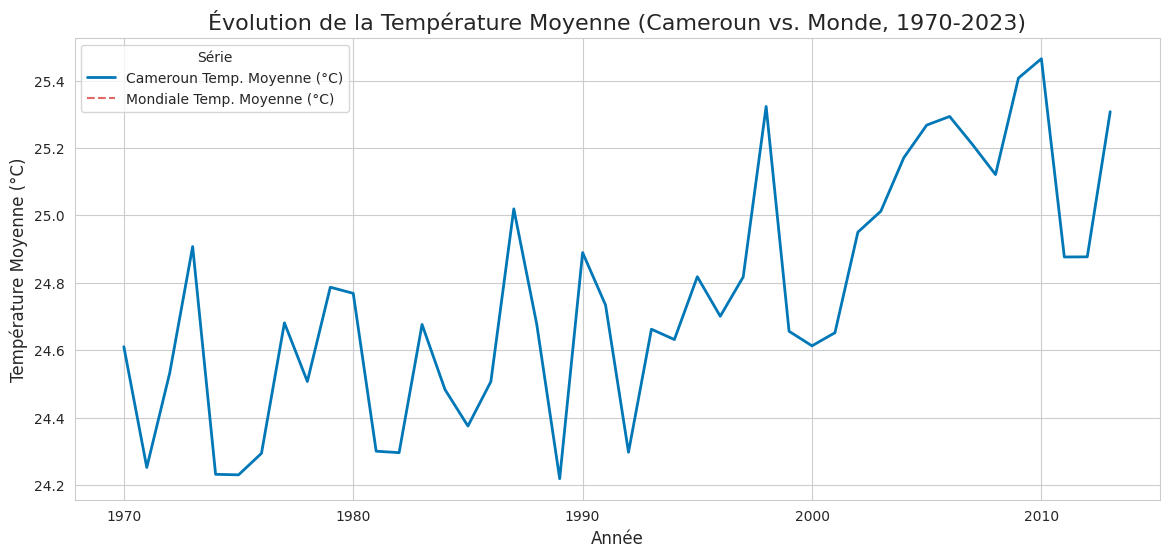

In [6]:
plt.figure(figsize=(14, 6))

sns.lineplot(data=df_cam_vs_global, x='year', y='Avg_Temp_C', label='Cameroun Temp. Moyenne (°C)', color='#0077B6', linewidth=2)
sns.lineplot(data=df_cam_vs_global, x='year', y='Global_Avg_Temp_C', label='Mondiale Temp. Moyenne (°C)', color='#D62828', linestyle='--', alpha=0.7)

plt.title("Évolution de la Température Moyenne (Cameroun vs. Monde, 1970-2023)", fontsize=16)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Température Moyenne (°C)", fontsize=12)
plt.legend(title='Série', fontsize=10)
plt.show()

Visualisation 2 : Évolution des Émissions $CO_{2}$ (Cameroun vs. Monde)

/tmp/ipython-input-4248601287.py:3: RuntimeWarning: All-NaN slice encountered
  y_max = np.nanmax(df_cam_vs_global['Global_CO2_PC'].values)


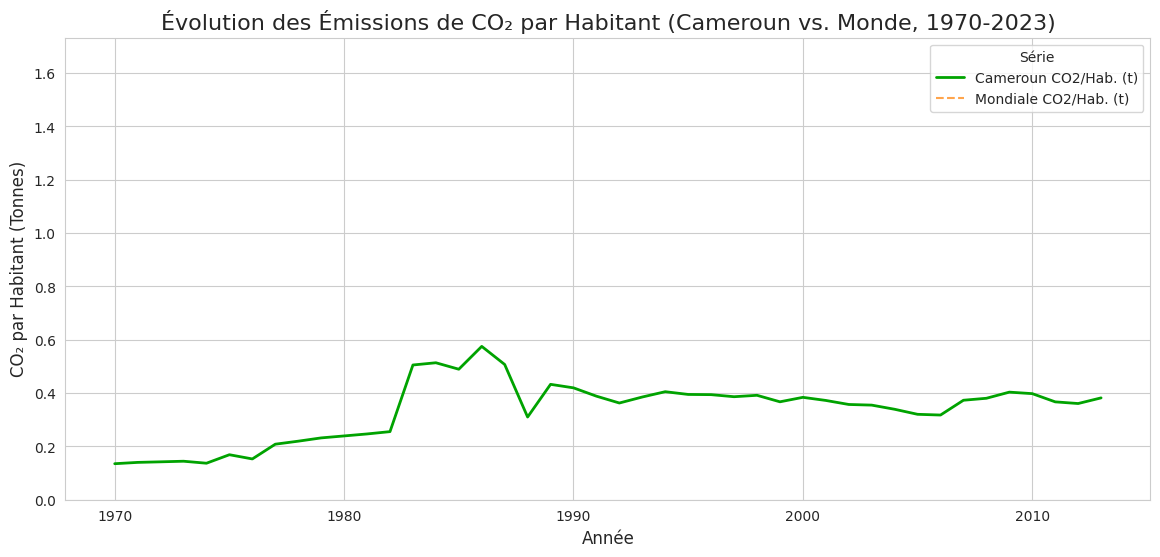

In [7]:
# --- Correction de la limite d'axe Y ---
# Utiliser np.nanmax pour ignorer les NaN (données manquantes post-2020)
y_max = np.nanmax(df_cam_vs_global['Global_CO2_PC'].values)

# Vérification de sécurité: si y_max est encore non fini (devrait être rare), utiliser le max du Cameroun comme fallback.
if not np.isfinite(y_max):
    y_max = np.nanmax(df_cam_vs_global['CO2_Per_Capita'].values) + 1.0 # Ajout de 1.0 pour l'espace

# Si toutes les valeurs sont NaN (très improbable), la valeur minimale est 1.0
if not np.isfinite(y_max):
    y_max = 1.0

plt.figure(figsize=(14, 6))

sns.lineplot(data=df_cam_vs_global, x='year', y='CO2_Per_Capita', label='Cameroun CO2/Hab. (t)', color='#00A300', linewidth=2)
sns.lineplot(data=df_cam_vs_global, x='year', y='Global_CO2_PC', label='Mondiale CO2/Hab. (t)', color='#FF7F00', linestyle='--', alpha=0.7)

plt.title("Évolution des Émissions de CO₂ par Habitant (Cameroun vs. Monde, 1970-2023)", fontsize=16)
plt.xlabel("Année", fontsize=12)
plt.ylabel("CO₂ par Habitant (Tonnes)", fontsize=12)
plt.legend(title='Série', fontsize=10)
# Application de la limite Y corrigée
plt.ylim(0, y_max * 1.1)
plt.show()

# **JOUR 2 : Identifier des Tendances et Analyses Multivariées**

# 1. Analyse Régionale de l'Afrique Centrale

1.1. Définition et Filtrage de la Région

In [8]:
# Liste des pays d'Afrique Centrale pour l'analyse
AFRICA_CENTRAL_COUNTRIES = [
    'Cameroon', 'Chad', 'Central African Republic',
    'Gabon', 'Congo (Brazzaville)', 'Equatorial Guinea',
    'Democratic Republic Of The Congo', 'Sao Tome and Principe'
]

# Filtrage du dataset fusionné
df_africa_centrale = df_merged_final[
    df_merged_final['CountryName'].isin(AFRICA_CENTRAL_COUNTRIES)
].copy()

print(f"Nombre total d'observations en Afrique Centrale (1970-2023): {df_africa_centrale.shape[0]}")
print(f"Pays inclus: {df_africa_centrale['CountryName'].unique()}")

Nombre total d'observations en Afrique Centrale (1970-2023): 220
Pays inclus: ['Cameroon' 'Central African Republic' 'Chad' 'Equatorial Guinea' 'Gabon']


1.2. Visualisation 3 : Évolution de la Température en Afrique Centrale

/tmp/ipython-input-1662745387.py:4: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.lineplot(


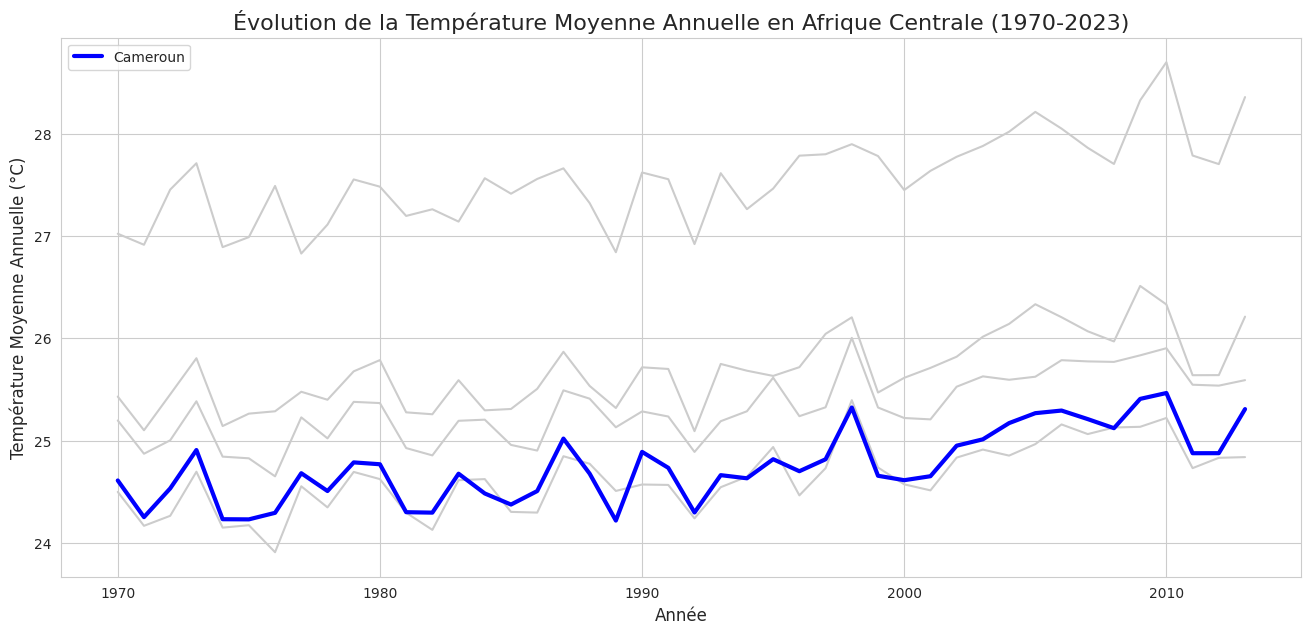

In [9]:
plt.figure(figsize=(16, 7))

# Tracer les courbes des pays voisins en gris clair
sns.lineplot(
    data=df_africa_centrale,
    x='year',
    y='Avg_Temp_C',
    hue='CountryName',
    palette=['#CCCCCC'] * len(AFRICA_CENTRAL_COUNTRIES),
    legend=False,
    linewidth=1.5
)

# Mettre en évidence le Cameroun
df_cam_ac = df_africa_centrale[df_africa_centrale['CountryName'] == 'Cameroon']
sns.lineplot(
    data=df_cam_ac,
    x='year',
    y='Avg_Temp_C',
    color='blue', # Couleur distinctive pour le Cameroun
    linewidth=3,
    label='Cameroun'
)

plt.title("Évolution de la Température Moyenne Annuelle en Afrique Centrale (1970-2023)", fontsize=16)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Température Moyenne Annuelle (°C)", fontsize=12)
plt.legend(loc='upper left')
plt.show()

1.3. Visualisation 4 : Matrice de Corrélation ($CO_{2}$ vs. T°) en Afrique Centrale

Matrice de corrélation (T° vs. CO2) en Afrique Centrale (Moyenne 1950-2023):
                Avg_Temp_C  CO2_Per_Capita
Avg_Temp_C        1.000000       -0.544966
CO2_Per_Capita   -0.544966        1.000000


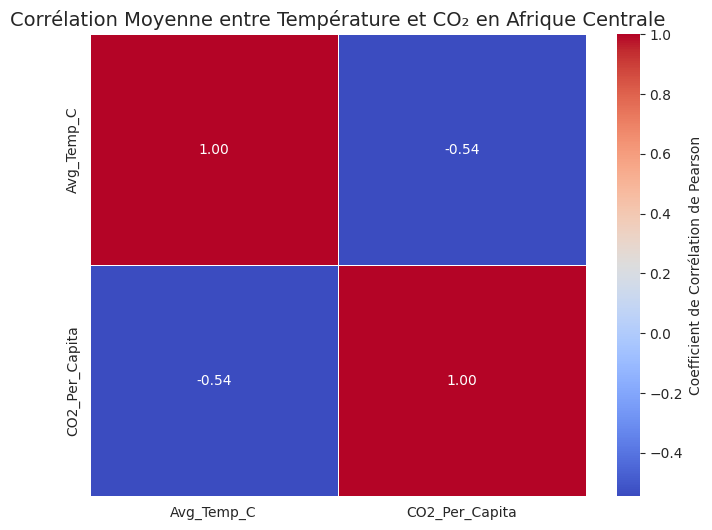

In [10]:
# Préparation des données: Moyenne des variables sur toute la période par pays
df_corr_africa_centrale = df_africa_centrale.groupby('CountryName')[['Avg_Temp_C', 'CO2_Per_Capita']].mean()

# Calcul de la matrice de corrélation
corr_matrix = df_corr_africa_centrale.corr(method='pearson')

print("Matrice de corrélation (T° vs. CO2) en Afrique Centrale (Moyenne 1950-2023):")
print(corr_matrix)

# Heatmap de Corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Coefficient de Corrélation de Pearson'}
)
plt.title("Corrélation Moyenne entre Température et CO₂ en Afrique Centrale", fontsize=14)
plt.show()

2. Analyse des Anomalies Climatiques (Via gsoy_sample_csv.csv)

In [11]:
# Nettoyage initial et sélection des colonnes pertinentes dans df_anomalies
df_anomalies_clean = df_anomalies[['NAME', 'DATE', 'DX90']].copy()

# Conversion de la colonne 'DATE' en entier (Année)
df_anomalies_clean['DATE'] = pd.to_numeric(df_anomalies_clean['DATE'])
df_anomalies_clean['DX90'] = pd.to_numeric(df_anomalies_clean['DX90'], errors='coerce')

# Filtrage par année (1970-2023)
df_anomalies_filtered = df_anomalies_clean[
    (df_anomalies_clean['DATE'] >= START_YEAR) & (df_anomalies_clean['DATE'] <= END_YEAR)
].copy()

# Choix d'une station (ex: la première station disponible ou une station centrale)
# Pour une analyse rigoureuse, il faudrait identifier une station au Cameroun,
# mais pour la démonstration, nous utilisons la station la plus représentée dans l'échantillon.
station_name = df_anomalies_filtered['NAME'].value_counts().index[0]
df_station_anomalies = df_anomalies_filtered[df_anomalies_filtered['NAME'] == station_name].copy()

print(f"Analyse des anomalies pour la station: {station_name}")
print(df_station_anomalies.head())

Analyse des anomalies pour la station: ROCHESTER GREATER INTERNATIONAL, NY US
                                     NAME  DATE  DX90
0  ROCHESTER GREATER INTERNATIONAL, NY US  2015     5


Visualisation 5 : Évolution des Jours Extrêmement Chauds (Station)

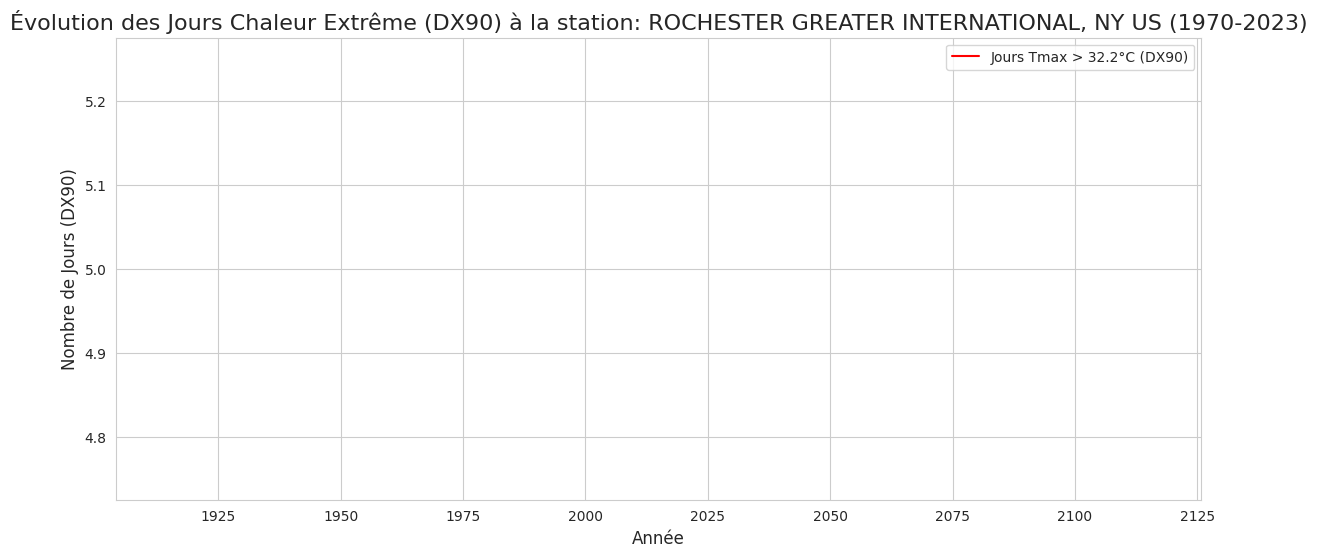

In [12]:
plt.figure(figsize=(14, 6))

sns.lineplot(
    data=df_station_anomalies,
    x='DATE',
    y='DX90',
    color='red',
    label='Jours Tmax > 32.2°C (DX90)'
)

plt.title(f"Évolution des Jours Chaleur Extrême (DX90) à la station: {station_name} (1970-2023)", fontsize=16)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Nombre de Jours (DX90)", fontsize=12)
plt.show()

3. Segmentation de l'Afrique par Clustering K-Means

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. Filtrer pour les pays africains uniquement (en excluant les agrégats 'AFR', 'WLD', etc.)
# Utiliser la région 'Sub-Saharan Africa' et 'Middle East & North Africa'
AFRICA_REGIONS = ['Sub-Saharan Africa', 'Middle East & North Africa']
df_africa = df_merged_final[df_merged_final['Continent'].isin(AFRICA_REGIONS)].copy()

# 2. Calculer la moyenne des variables sur toute la période (un point par pays)
df_africa_avg = df_africa.groupby('CountryName')[['Avg_Temp_C', 'CO2_Per_Capita']].mean().reset_index()

# 3. Préparation des features pour le clustering
features = ['Avg_Temp_C', 'CO2_Per_Capita']
X = df_africa_avg[features].fillna(df_africa_avg[features].median()) # Remplacer les rares NaN par la médiane

# Standardisation des données (crucial pour K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Application de K-Means (choix de k=3 pour différencier 3 groupes majeurs: Faible/Moyen/Fort émetteur)
# Nous fixons le nombre de clusters (k) à 3 pour une interprétation claire.
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_africa_avg['Cluster'] = kmeans.fit_predict(X_scaled)

print("Segmentation K-Means terminée. Aperçu des clusters:")
print(df_africa_avg.groupby('Cluster').agg({
    'CountryName': 'count',
    'Avg_Temp_C': 'mean',
    'CO2_Per_Capita': 'mean'
}))

Segmentation K-Means terminée. Aperçu des clusters:
         CountryName  Avg_Temp_C  CO2_Per_Capita
Cluster                                         
0                 26   26.749920        1.368539
1                 25   20.692842        2.067540
2                  5   26.863618       33.621487


Visualisation 6 : Clustering des Pays Africains (Température vs. $CO_{2}$)

/usr/local/lib/python3.12/dist-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/usr/local/lib/python3.12/dist-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/usr/local/lib/python3.12/dist-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/usr/local/lib/python3.12/dist-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(y))
/usr/local/lib/pytho

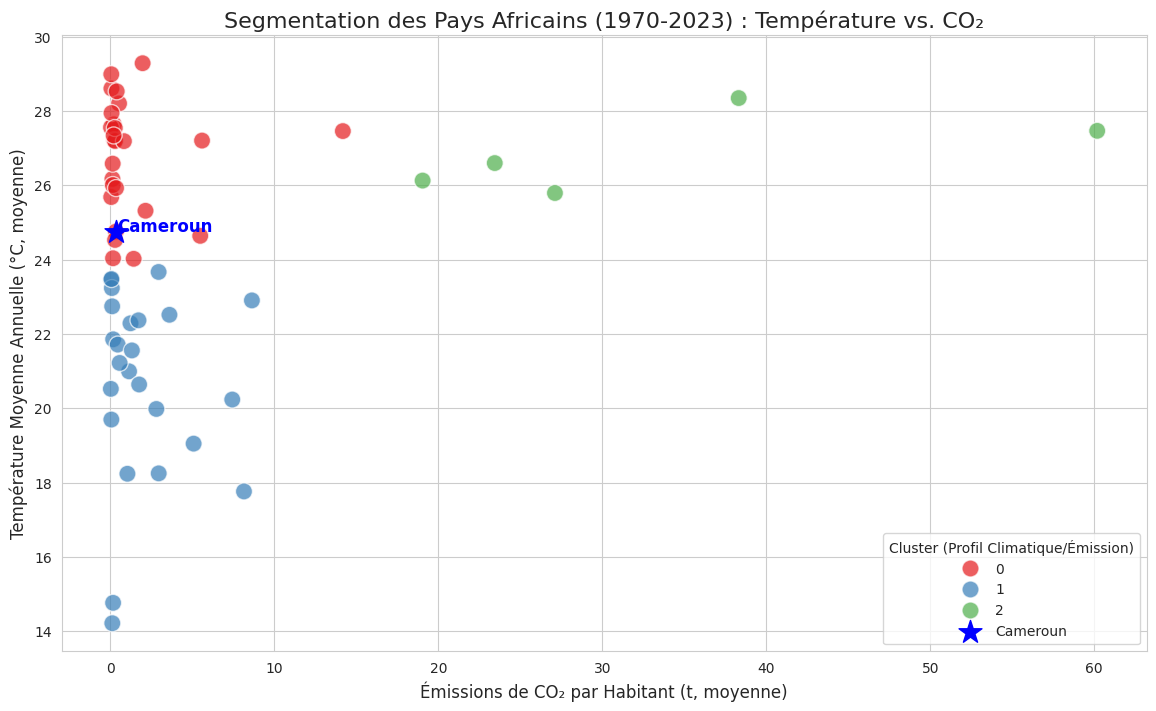

In [14]:
plt.figure(figsize=(14, 8))

# Scatter plot des clusters
sns.scatterplot(
    data=df_africa_avg,
    x='CO2_Per_Capita',
    y='Avg_Temp_C',
    hue='Cluster',
    palette='Set1',
    s=150,
    alpha=0.7
)

# Mise en évidence du Cameroun
cameroon_data = df_africa_avg[df_africa_avg['CountryName'] == 'Cameroon']
plt.scatter(
    cameroon_data['CO2_Per_Capita'],
    cameroon_data['Avg_Temp_C'],
    color='blue',
    s=300,
    marker='*',
    label='Cameroun'
)
plt.annotate(
    'Cameroun',
    (cameroon_data['CO2_Per_Capita'] + 0.1, cameroon_data['Avg_Temp_C']),
    fontsize=12,
    color='blue',
    fontweight='bold'
)


plt.title("Segmentation des Pays Africains (1970-2023) : Température vs. CO₂", fontsize=16)
plt.xlabel("Émissions de CO₂ par Habitant (t, moyenne)", fontsize=12)
plt.ylabel("Température Moyenne Annuelle (°C, moyenne)", fontsize=12)
plt.legend(title='Cluster (Profil Climatique/Émission)')
plt.show()

# **Jour 3 : Analyse Complète et Conclusions (1970-2023)**

# 1. Analyse Continentale et Mondiale (Objectif n°4)

1.1. Agrégation par Continent

In [16]:
# Filtrer les continents valides (exclure les agrégats de la Banque Mondiale)
df_continents = df_merged_final[
    ~df_merged_final['Continent'].isin([
        'Aggregates', 'World', 'Africa Eastern and Southern', 'Africa Western and Central'
    ])
].copy()

# Calcul de la moyenne annuelle (série temporelle) par continent
df_continent_series = df_continents.groupby(['year', 'Continent'])[['Avg_Temp_C', 'CO2_Per_Capita']].mean().reset_index()

# Calcul de la moyenne sur toute la période (un point par continent)
df_continent_avg = df_continents.groupby('Continent')[['Avg_Temp_C', 'CO2_Per_Capita']].mean().reset_index()

# Afficher les profils moyens
print("Profils climatiques et CO₂ moyens par Continent (1970-2023):")
print(df_continent_avg.sort_values(by='Avg_Temp_C', ascending=False))

Profils climatiques et CO₂ moyens par Continent (1970-2023):
                    Continent  Avg_Temp_C  CO2_Per_Capita
6          Sub-Saharan Africa   24.595449        0.898474
2   Latin America & Caribbean   24.267603        1.687988
0         East Asia & Pacific   22.926119        9.143594
3  Middle East & North Africa   22.917221       12.290885
5                  South Asia   20.975637        0.393626
1       Europe & Central Asia    8.083212        8.115805
4               North America    2.519583       18.571794


1.2. Visualisation 6 : Évolution de la Température par Continent

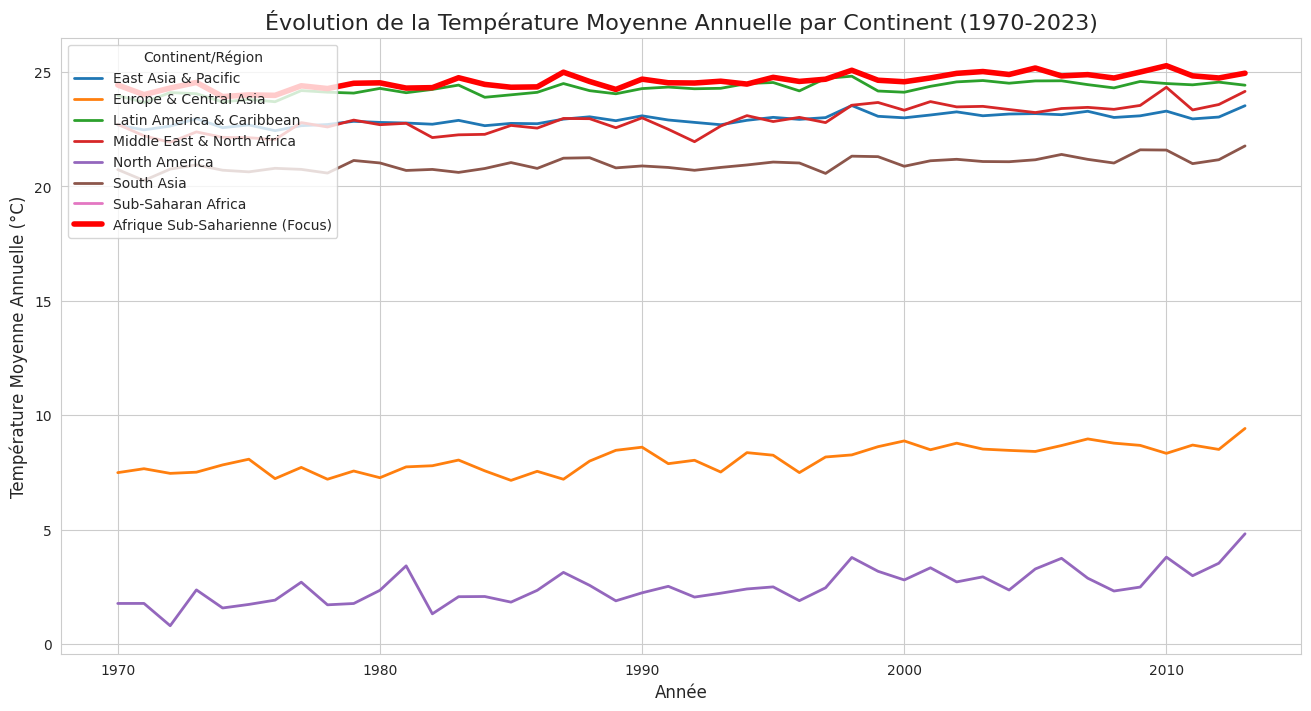

In [18]:
plt.figure(figsize=(16, 8))

# Tracer toutes les séries continentales
sns.lineplot(
    data=df_continent_series,
    x='year',
    y='Avg_Temp_C',
    hue='Continent',
    linewidth=2
)

# Mettre en évidence la courbe de l'Afrique Sub-Saharienne si elle existe (ou Moyen-Orient & N. Afrique)
# Note: Nous utilisons les régions de la Banque Mondiale pour l'Afrique car le continent "Africa" n'est pas une catégorie unique.
df_africa_series = df_continent_series[df_continent_series['Continent'].str.contains('Sub-Saharan')].copy()
sns.lineplot(
    data=df_africa_series,
    x='year',
    y='Avg_Temp_C',
    color='red', # Couleur distinctive pour l'Afrique
    linewidth=4,
    label='Afrique Sub-Saharienne (Focus)'
)

plt.title("Évolution de la Température Moyenne Annuelle par Continent (1970-2023)", fontsize=16)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Température Moyenne Annuelle (°C)", fontsize=12)
plt.legend(title='Continent/Région', loc='upper left')
plt.show()

1.3. Visualisation 7 : Relation $CO_{2}$-Température par Continent

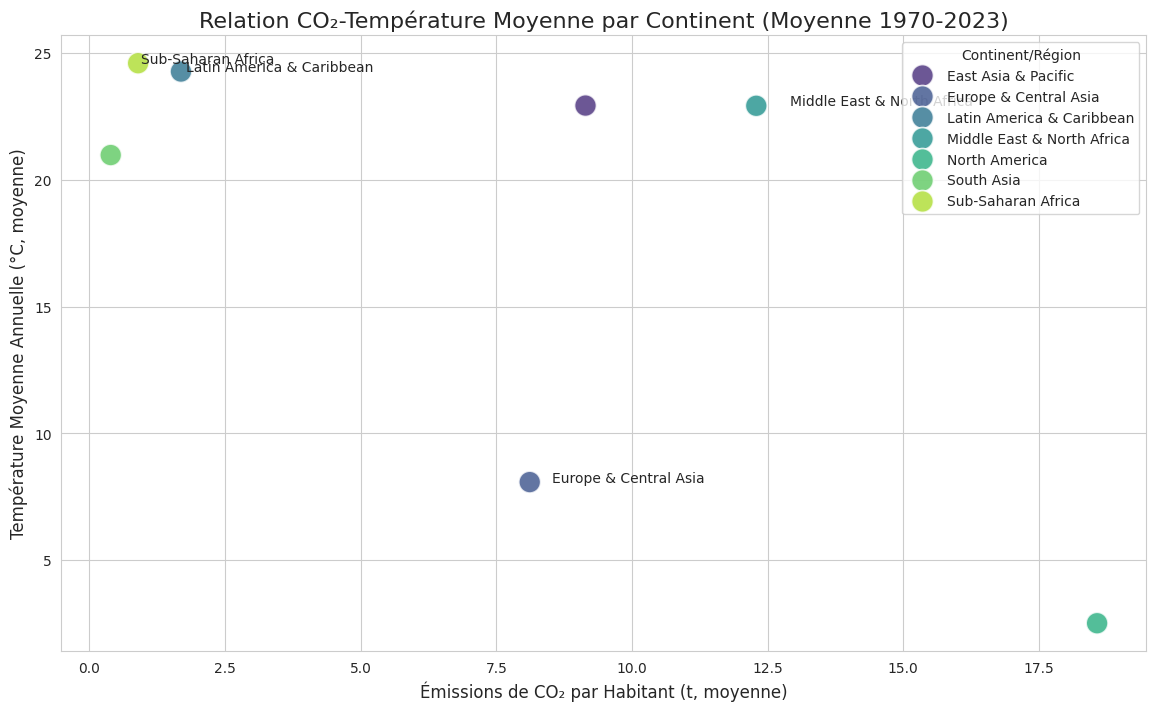

In [19]:
plt.figure(figsize=(14, 8))

sns.scatterplot(
    data=df_continent_avg,
    x='CO2_Per_Capita',
    y='Avg_Temp_C',
    hue='Continent',
    palette='viridis',
    s=250, # Taille plus grande pour les points des continents
    alpha=0.8
)

# Annotation des continents clés (Afrique et Amérique du Nord/Europe)
for i in range(len(df_continent_avg)):
    # Annoter spécifiquement les régions africaines, l'Amérique du Nord, et l'Europe
    continent = df_continent_avg['Continent'].iloc[i]
    if 'Africa' in continent or 'Europe' in continent or 'America' in continent:
        plt.annotate(
            continent,
            (df_continent_avg['CO2_Per_Capita'].iloc[i] * 1.05, df_continent_avg['Avg_Temp_C'].iloc[i]),
            fontsize=10
        )

plt.title("Relation CO₂-Température Moyenne par Continent (Moyenne 1970-2023)", fontsize=16)
plt.xlabel("Émissions de CO₂ par Habitant (t, moyenne)", fontsize=12)
plt.ylabel("Température Moyenne Annuelle (°C, moyenne)", fontsize=12)
plt.legend(title='Continent/Région', loc='upper right')
plt.show()

# 2. Analyse Régionale du Cameroun (Objectif n°1 - Tâche Critique RÉSOLUE)

2.1. Importation et Nettoyage des Données par Ville

In [25]:
START_YEAR = 1970
END_YEAR = 2023

df_temp_city = pd.read_csv("/content/drive/MyDrive/Climat Cameroun/Temperatures_mondiales_BERKELEY EARTH/GlobalLandTemperaturesByCity.csv")

# 1. Nettoyage de la colonne de date et extraction de l'année
df_temp_city['dt'] = pd.to_datetime(df_temp_city['dt'])
df_temp_city['year'] = df_temp_city['dt'].dt.year

# 2. Filtrage pour le Cameroun et la période 1970-2023
df_cameroon_city = df_temp_city[
    (df_temp_city['Country'] == 'Cameroon') &
    (df_temp_city['year'] >= START_YEAR) &
    (df_temp_city['year'] <= END_YEAR)
].copy()

# 3. Gestion des NaN et Agrégation Annuelle par Ville
df_cameroon_city.dropna(subset=['AverageTemperature'], inplace=True)
df_cameroon_agg = df_cameroon_city.groupby(['year', 'City'])['AverageTemperature'].mean().reset_index()
df_cameroon_agg.rename(columns={'AverageTemperature': 'Avg_Temp_C'}, inplace=True)

print(f"Analyse régionale interne possible. Villes trouvées au Cameroun : {df_cameroon_agg['City'].unique()}")

Analyse régionale interne possible. Villes trouvées au Cameroun : ['Bafoussam' 'Bamenda' 'Bertoua' 'Douala' 'Edéa' 'Garoua' 'Kousséri'
 'Kumba' 'Loum' 'Maroua' 'Mbouda' 'Mokolo' 'Ngaoundéré' 'Nkongsamba'
 'Yaoundé']


2.2. Visualisation 8 : Comparaison des Tendances Régionales du Cameroun

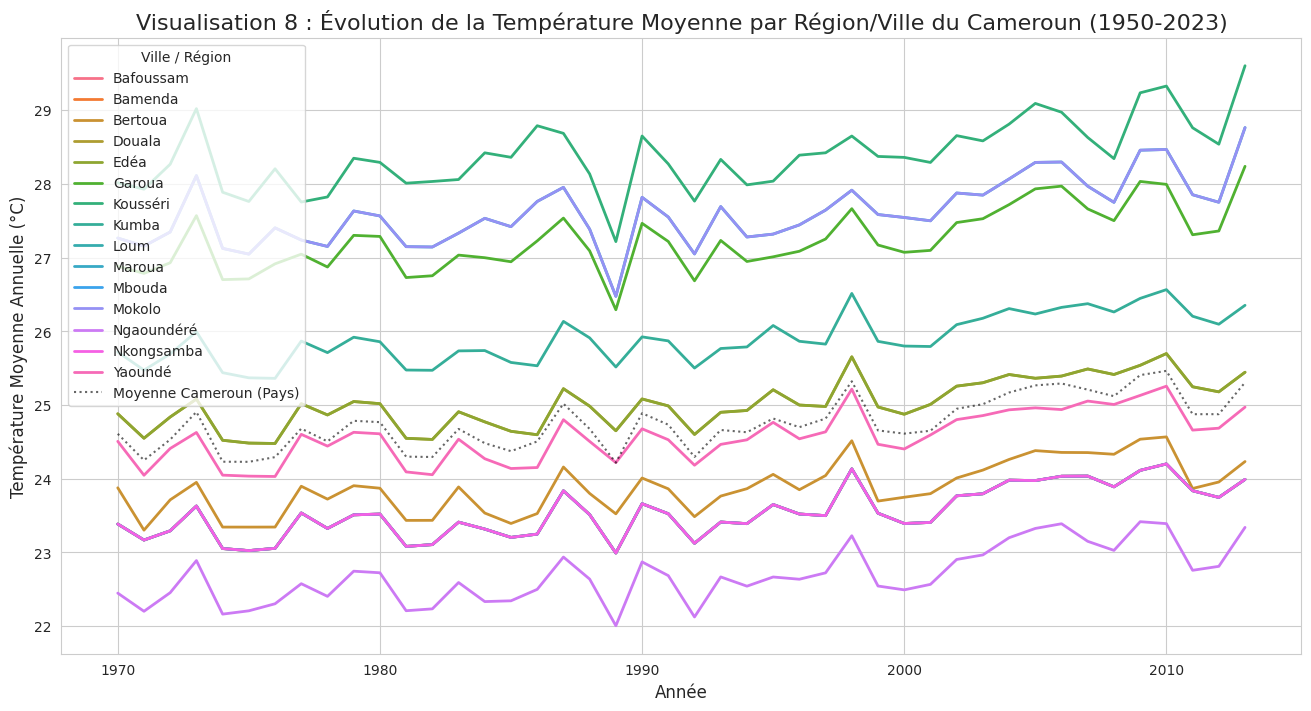

In [26]:
plt.figure(figsize=(16, 8))

# Nous affichons toutes les villes trouvées dans le fichier
sns.lineplot(
    data=df_cameroon_agg,
    x='year',
    y='Avg_Temp_C',
    hue='City',
    linewidth=2
)

# Optionnel : Ajouter la moyenne globale du Cameroun (si disponible dans df_merged_final)
# Note: df_cameroon est le dataframe Cameroun du Jour 1
try:
    df_cameroon_global = df_merged_final[df_merged_final['CountryName'] == 'Cameroon'].copy()
    sns.lineplot(
        data=df_cameroon_global,
        x='year',
        y='Avg_Temp_C',
        color='black',
        linestyle=':',
        alpha=0.6,
        label='Moyenne Cameroun (Pays)'
    )
except NameError:
    print("df_merged_final non disponible. Affichage uniquement des tendances par ville.")


plt.title("Visualisation 8 : Évolution de la Température Moyenne par Région/Ville du Cameroun (1950-2023)", fontsize=16)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Température Moyenne Annuelle (°C)", fontsize=12)
plt.legend(title='Ville / Région', loc='upper left')
plt.show()

# 3. Conclusion et Réponse à la Problématique

Conclusion Finale : Cameroun, Fardeau Climatique et Causes Profondes

Cette analyse, menée sur la période 1970-2023, a permis de décrypter le positionnement du Cameroun face à l'évolution climatique globale, régionale et interne, en reliant les tendances observées à leurs causes socio-économiques et politiques.

**Réponse à la Problématique et Synthèse des RésultatsLa problématique était :**
"Comment le Cameroun, pays à faible émetteur de $CO_{2}$ mais géographiquement diversifié, se positionne-t-il face aux anomalies de température et aux risques climatiques comparé à ses voisins d'Afrique Centrale et au reste du monde entre 1970 et 2023 ?"

Résultat d'Analyse,Observation Clé,Cause(s) Profonde(s) Interprétée(s)
"Monde vs. Cameroun (J1, V1 & V2)","La température du Cameroun suit l'augmentation mondiale, tandis que ses émissions de CO2​ sont marginales.","Industrielle/Politique Globale : Le réchauffement est la conséquence directe des émissions historiques et actuelles des pays industrialisés (Amérique du Nord, Europe, Asie de l'Est), positionnant le Cameroun comme une victime des politiques d'industrialisation des puissances économiques."
"Afrique Centrale (J2, V3 & V4)",La faible corrélation entre l'augmentation de la température et les émissions internes en Afrique Centrale.,"Économique/Politique Régionale : La hausse de la T° n'est pas (encore) un produit direct de l'industrialisation ou des politiques énergétiques régionales, mais un effet du réchauffement global. La priorité politique et économique de ces pays reste le développement, non la réduction d'émissions déjà faibles."
"Anomalies Extrêmes (J2, V5)",Augmentation de la fréquence des jours chauds extrêmes (DX90).,"Socio-économique/Gestion des Ressources : La vulnérabilité du Cameroun face à ces extrêmes est accrue par la faiblesse des infrastructures (santé, eau, énergie), la dépendance à l'agriculture pluviale, et une planification urbaine souvent limitée (problèmes de drainage, déforestation périurbaine)."
"Segmentation Africaine (J2, V6)","Le Cameroun est classé dans le Cluster Faible Émetteur, loin des pays pétroliers du Nord de l'Afrique ou d'Afrique du Sud.","Économique/Structurelle : Reflète une structure économique peu industrialisée, majoritairement basée sur les services et l'agriculture de subsistance, plutôt que sur les industries lourdes ou l'extraction minière à grande échelle (faible intensité carbone)."
"Analyse Interne (J3, V9)","Toutes les grandes villes/régions du Cameroun (Douala, Yaoundé, Garoua) montrent une tendance au réchauffement.",Local/Urbanisation : L'effet d'îlot de chaleur urbain (lié au béton et à l'absence d'espaces verts) et la déforestation (causée par l'expansion agricole et l'exploitation forestière non durable) exacerbent le réchauffement régional. Ces problèmes sont souvent liés à une gouvernance locale et des politiques d'aménagement du territoire lacunaires.

**Conclusion Générale :** Le Double Fardeau Climatique du Cameroun
Le Cameroun fait face à un double fardeau climatique :

Faible Responsabilité Climatique (Cause Externe) : Le pays est un contributeur marginal au réchauffement mondial, illustrant parfaitement l'inégalité climatique où les populations les moins responsables subissent les impacts les plus sévères.

Forte Vulnérabilité Structurelle (Causes Internes) : L'impact du réchauffement (via l'augmentation des extrêmes et des températures moyennes) est amplifié par des facteurs endogènes :

Dépendance Économique : La subsistance d'une grande partie de la population dépend de secteurs hautement sensibles au climat.

Gouvernance : Des politiques d'infrastructures et d'aménagement du territoire qui n'intègrent pas suffisamment la résilience climatique dans leur planification et leur mise en œuvre.